In [364]:
# import libraries
import requests
import re
!pip3.6 install python-rake
import RAKE
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
from pymorphy2.tokenizers import simple_word_tokenize
from gensim.summarization import keywords as kw
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
rus_stopwords = stopwords.words('russian')
morph_analyzer = MorphAnalyzer()
NUM_OF_WORDS = 15

1. Подготовить мини-корпус (4-5 текстов или до 10 тысяч токенов) с разметкой ключевых слов. Желательно указать источник корпуса и описать, в каком виде там были представлены ключевые слова.

In [0]:
# Source: https://www.novayagazeta.ru/
# Keywords: "Теги"

urls = [
    "https://www.novayagazeta.ru/articles/2019/11/15/82747-v-rossiyskoy-armii-net-primerov-muzhelozhestva",
    "https://www.novayagazeta.ru/articles/2019/11/16/82753-musor-revolyutsiya-edinstvo",
    "https://www.novayagazeta.ru/articles/2019/11/14/82737-promezhutochnye-itogi-vyborov-v-ran",
    "https://www.novayagazeta.ru/articles/2019/11/14/82731-eto-ne-ya-vas-pytal",
    "https://www.novayagazeta.ru/articles/2019/11/06/82631-byudzhet-na-povyshennyh-tonah"
]

In [0]:
texts = []
true_keywords = []
for url in urls:
    html_ = requests.get(url).text
    text = '\n'.join([line.strip() for line in re.findall('(?:<p .*?>|<p>)(.*?)</p>', html_, re.DOTALL) if line and line != '&lt;&hellip;&gt;'][:-8])
    text = re.sub('<[^<>]*?>', '', text)
    text = re.sub('\n\r', '\n', text)
    text = re.sub('\n+', '\n', text)
    texts.append(text)
    article_keywords = re.search('<div[^<>]*?><h5[^<>]*?>Теги: </h5>(.*?)</div>', html_).group(1)
    article_keywords = re.findall('<a[^<>]*?>(.*?)</a>', article_keywords, re.DOTALL)
    true_keywords.append(article_keywords)

In [0]:
for i, text in enumerate(texts):
    for symbol in ['&raquo', '&laquo', '&mdash', '&nbsp']:
        texts[i] = texts[i].replace(symbol, '')

In [369]:
for keyword_list in true_keywords:
    print(keyword_list)

['минобороны', 'убийство', 'дедовщина', 'военнослужащие', 'армия', 'россия']
['протесты', 'экология', 'мусорный полигон', 'экоактивисты', 'архангельская область', 'шиес']
['лженаука', 'фальсификация', 'плагиат', 'россия', 'голосование', 'российская академия наук']
['анархисты', 'пенза', 'дело сети']
['бюджет', 'мосгордума', 'москва', 'общественные слушания']


2. Разметить ключевые слова самостоятельно. Оценить пересечение с имеющейся разметкой.

In [0]:
our_keywords = [
    ['изнасилование', 'мужеложство', 'армия', 'дедовщина', 'солдат', 'мат', 'караул', 'комиссия'],
    ['шиес', 'палаточный лагерь', 'мусор', 'полигон', 'шлагбаум', 'митинг', 'чоп', 'дети'],
    ['диссернет', 'ран', 'выборы', 'диссертация', 'плагиат'],
    ['суд', 'сеть', 'пытки', 'пытать', 'дело', 'пенза', 'политика', 'фсб', 'следствие'],
    ['бюджет', 'деньги', 'доходы', 'публичные слушания', 'общественные слушания', 'московская городская дума', 'москва']
]

In [371]:
for i, (true_list, our_list) in enumerate(zip(true_keywords, our_keywords)):
    print(f'{i + 1}-й текст:', len(set(true_list) & set(our_list)) / (len(set(true_list) | set(our_list))))

1-й текст: 0.16666666666666666
2-й текст: 0.07692307692307693
3-й текст: 0.1
4-й текст: 0.09090909090909091
5-й текст: 0.375


3-4. Применить к этому корпусу 3 метода извлечения ключевых слов на выбор (RAKE, 
TextRank, tf*idf, OKAPI BM25).

Оценить точность, полноту, F-меру выбранных методов относительно имеющейся разметки.



In [0]:
def precision(true_list, our_list):
    tp = 0
    fp = 0
    for our_keyword in our_list:
        if our_keyword in true_list:
            tp += 1
        else:
            fp += 1
    return tp / (tp + fp)

In [0]:
def recall(true_list, our_list):
    tp = 0
    fn = 0
    for our_keyword in our_list:
        if our_keyword in true_list:
            tp += 1
    fn = len(true_list) - tp
    return tp / (tp + fn)

In [0]:
def f1(true_list, our_list):
    p = precision(true_list, our_list)
    r = recall(true_list, our_list)
    if not (p + r):
        return 0.0
    return 2 * p * r / (p + r)

In [0]:
def print_metrics(true_lists, our_lists):
    precisions = []
    recalls = []
    f1s = []
    for i, (true_list, our_list) in enumerate(zip(true_lists, our_lists)):
        p = precision(true_list, our_list)
        precisions.append(p)
        r = recall(true_list, our_list)
        recalls.append(r)
        f1_value = f1(true_list, our_list)
        f1s.append(f1_value)
        print(
            f'{i + 1}-й текст:\n'
            f'{our_list}\n'
            f'Precision: {p}\n'
            f'Recall: {r}\n'
            f'F1: {f1_value}\n'
        )
    mean_precision = sum(precisions) / len(precisions)
    mean_recall = sum(recalls) / len(recalls)
    mean_f1 = sum(f1s) / len(f1s)
    print(
        f'Mean Precision: {mean_precision}\n'
        f'Mean Recall: {mean_recall}\n'
        f'Mean F1: {mean_f1}\n'
    )
    return mean_precision, mean_recall, mean_f1

RAKE

In [0]:
rake = RAKE.Rake(rus_stopwords)

In [377]:
# без лемматизации
texts_keywords = []
for i, text in enumerate(texts):
    text_keywords = rake.run(text, maxWords=3, minFrequency=2)
    text_keywords = [pair[0] for pair in text_keywords]
    texts_keywords.append(text_keywords)

print_metrics(our_keywords, texts_keywords);

1-й текст:
['грубой форме', 'можете сказать', 'мирное время', 'шамсутдинов', 'это', 'однако', 'деньги', 'караул', 'трагедии', 'телефон', 'скорее', 'р', 'известно']
Precision: 0.07692307692307693
Recall: 0.125
F1: 0.09523809523809525

2-й текст:
['люди', 'работу', 'шиес', 'тревога', 'уверенность', 'сплоченность', 'здоровье', 'шлагбауме', 'чоповцами', 'шиесе', 'подумал']
Precision: 0.09090909090909091
Recall: 0.125
F1: 0.10526315789473685

3-й текст:
['ран', 'это', 'науке']
Precision: 0.3333333333333333
Recall: 0.2
F1: 0.25

4-й текст:
['экономический крен', 'николая антонова', 'это называется', 'пенза-пост', 'именно', 'пензе', 'фсб', 'токарев', 'это', 'суд', 'шматко', 'пенза', 'просто', 'сказал', 'дела', 'рассказывает', 'деле', 'действительно', 'сети', 'связи', 'сеть', 'городе', 'шарипков', 'решим', 'подсудимые', 'кем', 'думаю', 'вскроется', 'сплоченность', 'судя', 'всему']
Precision: 0.12903225806451613
Recall: 0.4444444444444444
F1: 0.19999999999999998

5-й текст:
['публичные слушания

In [0]:
def normalize_text(text):
    lemmas = []
    for t in simple_word_tokenize(text):
        lemmas.append(
            morph_analyzer.parse(t)[0].normal_form
        )
    return ' '.join(lemmas)

In [0]:
normalized_our_keywords = [[normalize_text(keyword) for keyword in keywords] for keywords in our_keywords]
normalized_texts = [normalize_text(text) for text in texts]

In [380]:
# с лемматизацией
texts_keywords = []
for i in range(len(texts)):
    text_keywords = rake.run(normalized_texts[i], maxWords=3, minFrequency=2)
    text_keywords = [pair[0] for pair in text_keywords]
    texts_keywords.append(text_keywords)

rake_mean_precision, rake_mean_recall, rake_mean_f1 = print_metrics(normalized_our_keywords, texts_keywords)

1-й текст:
['совершить половый сношение', 'грубый форма', 'рядовой шамсутдинов', 'мирный время', 'отношение', 'караул', 'дедовщина', 'шамсутдин', 'который', 'это', 'однако', 'солдат', 'деньга', 'ходить', 'трагедия', 'телефон', 'история', 'применять', 'командир', 'скорее', 'р', 'известно']
Precision: 0.13636363636363635
Recall: 0.375
F1: 0.19999999999999998

2-й текст:
['регион', 'человек', 'пост', 'работа', 'шиес', 'тревога', 'уверенность', 'сплочённость', 'здоровье', 'узнать', 'шлагбаум', 'чоповца', 'поехать', 'подумать', 'разговаривать', 'улица']
Precision: 0.125
Recall: 0.25
F1: 0.16666666666666666

3-й текст:
['который', 'рана', 'это', 'наука', 'никто', 'писать']
Precision: 0.16666666666666666
Recall: 0.2
F1: 0.1818181818181818

4-й текст:
['поколение новое время', 'это называться', 'экономический крен', 'пенза-пост', 'заниматься политика', 'николай антонов', 'именно', 'который', 'это', 'фсб', 'пенза', 'суд', 'токарев', 'весь', 'дело', 'фашист', 'мочь', 'шматко', 'маленький', 'пытк

TextRank

In [381]:
# с лемматизацией
texts_keywords = []
for i in range(len(texts)):
    text_keywords = kw(normalized_texts[i], pos_filter=[], split=True, lemmatize=False, words=NUM_OF_WORDS)
    texts_keywords.append(text_keywords)

text_rank_mean_precision, text_rank_mean_recall, text_rank_mean_f1 = print_metrics(normalized_our_keywords, texts_keywords)

1-й текст:
['быть', 'что', 'это', 'солдат', 'служба', 'для', 'причина', 'возможность', 'свои', 'нет', 'шамсутдинов', 'отношение', 'погибшии', 'как', 'шамсутдин']
Precision: 0.06666666666666667
Recall: 0.125
F1: 0.08695652173913045

2-й текст:
['человек', 'они', 'что', 'как', 'это', 'весь', 'быть', 'когда', 'наш', 'стоять', 'даже', 'год', 'митинг', 'она', 'полиция']
Precision: 0.06666666666666667
Recall: 0.125
F1: 0.08695652173913045

3-й текст:
['что', 'научныи', 'которыи', 'кандидат', 'это', 'рана', 'свои', 'ученыи', 'этот', 'информационныи', 'быть', 'диссертация', 'академия', 'писать', 'тот']
Precision: 0.13333333333333333
Recall: 0.4
F1: 0.2

4-й текст:
['что', 'весь', 'это', 'дело', 'как', 'пензенскии', 'быть', 'токарев', 'пенза', 'они', 'которыи', 'против', 'так', 'сеть', 'обвинение']
Precision: 0.2
Recall: 0.3333333333333333
F1: 0.25

5-й текст:
['бюджет', 'депутат', 'что москва быть', 'это', 'весь', 'человек', 'которыи', 'публичныи слушание', 'участник', 'как', 'большои', 'сеича

TF-IDF

In [0]:
vectorizer = TfidfVectorizer(stop_words=rus_stopwords)
matrix = vectorizer.fit_transform(normalized_texts)

In [0]:
words = np.array(vectorizer.get_feature_names())

In [384]:
# с лемматизацией
texts_keywords = []
for i in range(len(texts)):
    text_keywords = words[np.argsort(matrix[i].toarray()).flatten()[::-1][:NUM_OF_WORDS]]
    texts_keywords.append(text_keywords)

tf_idf_mean_precision, tf_idf_mean_recall, tf_idf_mean_f1 = print_metrics(normalized_our_keywords, texts_keywords)

1-й текст:
['солдат' 'это' 'служба' 'шамсутдинов' 'караул' 'отношение' 'причина'
 'шамсутдин' 'дедовщина' 'погибший' 'минобороны' 'мочь' 'комиссия'
 'возможность' 'командир']
Precision: 0.26666666666666666
Recall: 0.5
F1: 0.3478260869565218

2-й текст:
['шиес' 'человек' 'наш' 'это' 'регион' 'активист' 'полиция' 'природа'
 'ездить' 'стоять' 'лагерь' 'чоповца' 'точка' 'шлагбаум' 'полигон']
Precision: 0.2
Recall: 0.375
F1: 0.26086956521739135

3-й текст:
['рана' 'научный' 'кандидат' 'писать' 'диссертация' 'наука' 'академия'
 'комиссия' 'информационный' 'фальсификация' 'учёный' 'который' 'это'
 'пройти' 'нарушение']
Precision: 0.13333333333333333
Recall: 0.4
F1: 0.2

4-й текст:
['сеть' 'весь' 'пензенский' 'токарев' 'пенза' 'дело' 'это' 'фсб' 'шматко'
 'пытка' 'обвинение' 'суд' 'город' 'против' 'который']
Precision: 0.4
Recall: 0.6666666666666666
F1: 0.5

5-й текст:
['бюджет' 'слушание' 'депутат' 'москва' 'общественный' 'палата' 'это'
 'публичный' 'участник' 'время' 'весь' 'расход' 'выступл

5. Описать ошибки автоматического выделения ключевых слов (что выделяется лишнее, что не выделяется); предложить свои методы решения этих проблем.

In [0]:
def draw_graph(values, labels, ylabel='Value'):
    assert len(values) == len(labels)
    fig, ax = plt.subplots()
    rects = ax.bar(range(len(values)), values, 0.5, color='g')
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.add(range(len(values)), 1/100))
    ax.set_xticklabels((labels))
    plt.show()

In [0]:
labels = ['RAKE', 'TextRank', 'tf-idf']

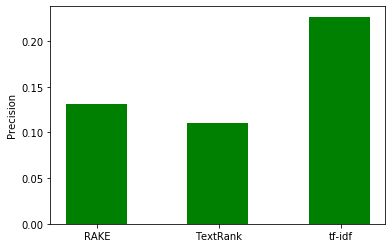

In [387]:
draw_graph([rake_mean_precision, text_rank_mean_precision, tf_idf_mean_precision], labels, ylabel='Precision')

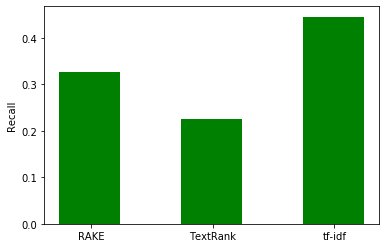

In [388]:
draw_graph([rake_mean_recall, text_rank_mean_recall, tf_idf_mean_recall], labels, ylabel='Recall')

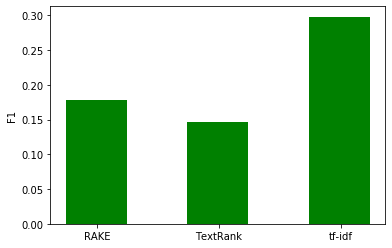

In [389]:
draw_graph([rake_mean_f1, text_rank_mean_f1, tf_idf_mean_f1], labels, ylabel='F1')

Несмотря на то, что tf-idf выделяет исключительно однословные ключевые слова, этот алгоритм показывает наилучшее качество по всем метрикам (по f1 как следствие из precision и recall). Вероятно, хотя бы отчасти это связано с тем, что я сам при выделении ключевых слов ориентировался на частотность; rake и TextRank тоже учитывают частотность, но в качестве нормирующего (поощрение слов, часто встречающихся в длинных фразах) и стохастически соответственно. Недостаток с униграммами (как получить "Московскую городскую думу" в 5-м тексте?) можно решить, если сделать tf-idf так же на биграммах, триграммах и n-граммах и выводить варианты с самыми большими значениями. Однако не очень понятно, уместно ли будет сравнивать tf-idf значения на униграммах и биграммах? т.к. tf биграмм будем явно меньше, чем униграмм. Возможно, правильнее будет набирать подходящие варианты (с самым большим значением tf) в уменьшающейся пропорции (например, 10 униграмм, 5 биграмм, 1 триграмму, т.к. мы на самом деле не очень ожидаем, что ключевые фразы будут состоять из очень большого количества слов).

Rake сам по себе отдаёт предпочтение более длинным последовательностям, тогда как у меня в "правильных" ответах преимущественно фразы из одного слова. Так, если будет какая-нибудь длинная фраза с уникальными словами, то она сразу выйдет в топ, поэтому мы ограничиваем алгоритм 3 словами (если больше, то больше шума). Но в результате, например, такие слова, как "полигон" во втором тексте не учитываются, т.к. входят в длинные последовательности. Возможно, с шумом надо бороться по-другому: на ум приходит в числителе не вес учитывать, а некоторую функцию от отношения частоты к общему количеству слов в тексте, например, перевёрнутую и сдвинутую по оси x вправо квадратичную функцию, т.к., на мой взгляд, если короткое слово часто встречается отдельно, а не только в составе длинных фраз, это не повод его "гасить", в этом случае нужна эвристика, насколько часто должно встречаться слово, чтобы считать его шумом (не вошедшим в стоп-слова), а когда наоборот признаком того, что слово является ключевым. Проблема наличия эвристики в том, что для разных жанров она, вероятно, будет своя, но, может быть, это не проблема, т.к. есть "No Free Lunch Theorem".

TextRank ведёт себя хуже всего, поскольку реализация в gensim-е так себе: даже с lemmatize=False он всё равно лемматизирует по-своему, что в итоге даёт "пензенскии", "публичныи", ... + нельзя передать стоп-слова. Если бы не это, то качество было бы лучше. Из-за случайного блуждания теоретически возможны не самые лучшие варианты. Даже если мы ограничимся чисто именными группами, нужно дополнительно отсеивать некоторые кейсы типа указательного местоимения "этот".